In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Setup matplotlib to display in notebook:
%matplotlib inline

In [3]:
df_prorated_imputed = pd.read_pickle("../output/NYCHA_Electricity_2010_to_2018_df_prorated_kwh_imputed")
df_prorated_imputed.head()

,Building_Meter,Month,Month_Type,Month_#_Days,Prorated_Days,Gap_Days,Gap_Type,Prorated_KWH,Imputed_KWH
0,165.0 - BLD 04_99273488,2009-12-01,First_Month,31,9.0,0.0,No Gap,19694.117647,67835.294118
1,165.0 - BLD 04_99273488,2010-01-01,Month_In_The_Middle,31,31.0,0.0,No Gap,68283.025210,68283.025210
2,165.0 - BLD 04_99273488,2010-02-01,Month_In_The_Middle,28,28.0,0.0,No Gap,61071.133005,61071.133005
3,165.0 - BLD 04_99273488,2010-03-01,Month_In_The_Middle,31,31.0,0.0,No Gap,58011.118077,58011.118077
4,165.0 - BLD 04_99273488,2010-04-01,Month_In_The_Middle,30,30.0,0.0,No Gap,55164.054336,55164.054336


In [4]:
df_one_building = df_prorated_imputed[df_prorated_imputed['Building_Meter']=='165.0 - BLD 03_90327795']
#df_one_building = df_prorated_imputed[df_prorated_imputed['Building_Meter']=='165.0 - BLD 04_99273488']

In [5]:
df_one_building = df_one_building.reset_index()
df_one_building.head()

,index,Building_Meter,Month,Month_Type,Month_#_Days,Prorated_Days,Gap_Days,Gap_Type,Prorated_KWH,Imputed_KWH
0,309,165.0 - BLD 03_90327795,2009-12-01,First_Month,31,9.0,0.0,No Gap,43920.000000,151280.000000
1,310,165.0 - BLD 03_90327795,2010-01-01,Month_In_The_Middle,31,31.0,0.0,No Gap,151382.857143,151382.857143
2,311,165.0 - BLD 03_90327795,2010-02-01,Month_In_The_Middle,28,28.0,0.0,No Gap,136106.798030,136106.798030
3,312,165.0 - BLD 03_90327795,2010-03-01,Month_In_The_Middle,31,31.0,0.0,No Gap,145210.950888,145210.950888
4,313,165.0 - BLD 03_90327795,2010-04-01,Month_In_The_Middle,30,30.0,0.0,No Gap,135622.152560,135622.152560


In [6]:
def sliding_chunker(data, window_len, slide_len):
    """
    Split a list into a series of sub-lists, each sub-list window_len long,
    sliding along by slide_len each time. If the list doesn't have enough
    elements for the final sub-list to be window_len long, the remaining data
    will be dropped.
    e.g. sliding_chunker(range(6), window_len=3, slide_len=2)
    gives [ [0, 1, 2], [2, 3, 4] ]
    """
    chunks = []
    for pos in range(0, len(data), slide_len):
        chunk = np.copy(data[pos:pos+window_len])
        if len(chunk) != window_len:
            continue
        chunks.append(chunk)

    return chunks

In [7]:
def plot_waves(waves, step):
    """
    Plot a set of 9 waves from the given set, starting from the first one
    and increasing in index by 'step' for each subsequent graph
    """
    plt.figure()
    n_graph_rows = 3
    n_graph_cols = 3
    graph_n = 1
    wave_n = 0
    for _ in range(n_graph_rows):
        for _ in range(n_graph_cols):
            axes = plt.subplot(n_graph_rows, n_graph_cols, graph_n)
            #axes.set_ylim([30000, 250000])
            axes.set_ylim([min(df_one_building['Imputed_KWH'])-10000, max(df_one_building['Imputed_KWH'])+10000])
            plt.plot(waves[wave_n])
            graph_n += 1
            wave_n += step
    # fix subplot sizes so that everything fits
    plt.tight_layout()
    plt.show()

In [8]:
def reconstruct(data, window, clusterer):
    """
    Reconstruct the given data using the cluster centers from the given
    clusterer.
    """
    window_len = len(window)
    slide_len = window_len/2
    segments = sliding_chunker(data, window_len, slide_len)
    reconstructed_data = np.zeros(len(data))
    for segment_n, segment in enumerate(segments):
        # window the segment so that we can find it in our clusters which were
        # formed from windowed data
        segment *= window
        nearest_match_idx = clusterer.predict(segment)[0]
        nearest_match = np.copy(clusterer.cluster_centers_[nearest_match_idx])

        pos = segment_n * slide_len
        reconstructed_data[pos:pos+window_len] += nearest_match

    return reconstructed_data

In [9]:
segment_len = 8
#slide_len = 2
slide_len = 1

segments = []
for start_pos in range(0, len(df_one_building['Imputed_KWH']), slide_len):
    end_pos = start_pos + segment_len
    # make a copy so changes to 'segments' doesn't modify the original data
    segment = np.copy(df_one_building['Imputed_KWH'][start_pos:end_pos])
    # if we're at the end and we've got a truncated segment, drop it
    if len(segment) != segment_len:
        continue
    segments.append(segment)

print("Produced %d waveform segments" % len(segments))

Produced 96 waveform segments


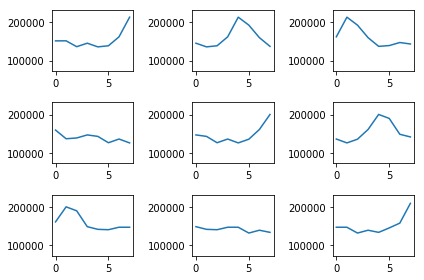

In [10]:
plot_waves(segments, step=3)

In [11]:
# window_rads = np.linspace(0, np.pi, segment_len)
# window = np.sin(window_rads)**2
# plt.plot(window)
# plt.show()

In [12]:
# windowed_segments = []
# for segment in segments:
#     windowed_segment = np.copy(segment) * window
#     windowed_segments.append(windowed_segment)

In [13]:
# plot_waves(windowed_segments, step=5)

In [14]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=20)
clusterer.fit(segments)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

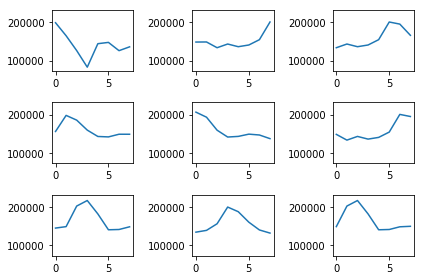

In [15]:
plot_waves(clusterer.cluster_centers_, step=2)

In [16]:
#slide_len = int(segment_len/2)
slide_len = 1
test_segments = sliding_chunker(
    df_one_building['Imputed_KWH'],
    window_len=segment_len,
    slide_len=slide_len
)

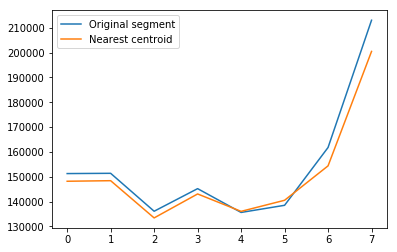

In [17]:
centroids = clusterer.cluster_centers_

segment = np.copy(test_segments[0])
# remember, the clustering was set up using the windowed data
# so to find a match, we should also window our search key
# windowed_segment = segment * window
# predict() returns a list of centres to cope with the possibility of multiple
# samples being passed
nearest_centroid_idx = clusterer.predict(test_segments[0].reshape(1,-1))[0]
nearest_centroid = np.copy(centroids[nearest_centroid_idx])
plt.figure()
plt.plot(segment, label="Original segment");
#plt.plot(windowed_segment, label="Windowed segment")
plt.plot(nearest_centroid, label="Nearest centroid");
plt.legend();
plt.show();

### Reconstruction

Maximum reconstruction error was 20630.9
99th percentile of reconstruction error was 15209.9


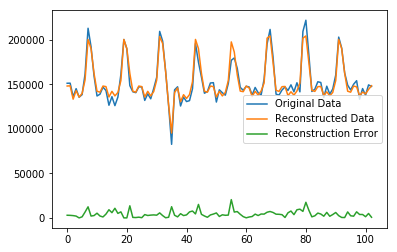

In [18]:
data = df_one_building['Imputed_KWH']
reconstruction = np.zeros(len(data))
#slide_len = segment_len/2
#slide_len = 2 

for segment_n, segment in enumerate(test_segments):
    # print(segment_n)
    # don't modify the data in segments
    segment = np.copy(segment)
    # segment *= window
    nearest_centroid_idx = clusterer.predict(segment.reshape(1,-1))[0]
    centroids = clusterer.cluster_centers_
    nearest_centroid = np.copy(centroids[nearest_centroid_idx])
    
    # overlay our reconstructed segments with an overlap of half a segment
    pos = int(segment_n * slide_len)
    reconstruction[pos:pos+segment_len] += nearest_centroid/(segment_len/slide_len)
    # if 35 > pos and 35 < pos+segment_len:
    #     plt.plot(np.linspace(1,8,8)+pos, nearest_centroid,label = pos)

# fix first segment_len and last segment_len data points since they are not modeled segment_len/slide_len times
for i in np.linspace(0,segment_len-1,segment_len).astype(int):
    reconstruction[i] = reconstruction[i]/(i+1)*(segment_len/slide_len)
    reconstruction[-i -1 ] = reconstruction[-i - 1]/(i+1)*(segment_len/slide_len)

n_plot_samples = 103
error = reconstruction[0:n_plot_samples] - data[0:n_plot_samples]
error_99th_percentile = np.percentile(error, 99)
print("Maximum reconstruction error was %.1f" % error.max())
print("99th percentile of reconstruction error was %.1f" % error_99th_percentile)

plt.plot(data[0:n_plot_samples], label="Original Data")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed Data")
plt.plot(np.abs(error[0:n_plot_samples]), label="Reconstruction Error")
plt.legend();
plt.show();

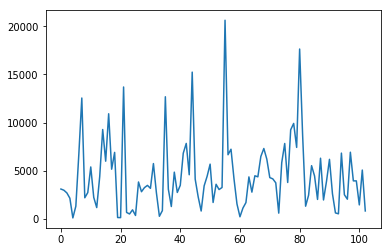

In [19]:
plt.plot(np.abs(error[0:n_plot_samples]), label="Reconstruction Error")
plt.show();

In [20]:
anomaly_entries = df_one_building[np.abs(error[0:n_plot_samples])>error_99th_percentile]
anomaly_entries

,index,Building_Meter,Month,Month_Type,Month_#_Days,Prorated_Days,Gap_Days,Gap_Type,Prorated_KWH,Imputed_KWH
44,353,165.0 - BLD 03_90327795,2013-08-01,Month_In_The_Middle,31,31.0,0.0,No Gap,174890.000000,174890.000000
55,364,165.0 - BLD 03_90327795,2014-07-01,Month_In_The_Middle,31,31.0,0.0,No Gap,177073.777778,177073.777778
80,389,165.0 - BLD 03_90327795,2016-08-01,Month_In_The_Middle,31,31.0,0.0,No Gap,222030.000000,222030.000000


In [21]:
df_one_building['Anomaly'] = np.where(np.abs(error[0:n_plot_samples])>error_99th_percentile, 'Yes', 'No')
df_one_building

,index,Building_Meter,Month,Month_Type,Month_#_Days,Prorated_Days,Gap_Days,Gap_Type,Prorated_KWH,Imputed_KWH,Anomaly
0,309,165.0 - BLD 03_90327795,2009-12-01,First_Month,31,9.0,0.0,No Gap,43920.000000,151280.000000,No
1,310,165.0 - BLD 03_90327795,2010-01-01,Month_In_The_Middle,31,31.0,0.0,No Gap,151382.857143,151382.857143,No
2,311,165.0 - BLD 03_90327795,2010-02-01,Month_In_The_Middle,28,28.0,0.0,No Gap,136106.798030,136106.798030,No
3,312,165.0 - BLD 03_90327795,2010-03-01,Month_In_The_Middle,31,31.0,0.0,No Gap,145210.950888,145210.950888,No
4,313,165.0 - BLD 03_90327795,2010-04-01,Month_In_The_Middle,30,30.0,0.0,No Gap,135622.152560,135622.152560,No
5,314,165.0 - BLD 03_90327795,2010-05-01,Month_In_The_Middle,31,31.0,0.0,No Gap,138498.574713,138498.574713,No
6,315,165.0 - BLD 03_90327795,2010-06-01,Month_In_The_Middle,30,30.0,0.0,No Gap,161783.666667,161783.666667,No
7,316,165.0 - BLD 03_90327795,2010-07-01,Month_In_The_Middle,31,31.0,0.0,No Gap,213036.379310,213036.379310,No
8,317,165.0 - BLD 03_90327795,2010-08-01,Month_In_The_Middle,31,31.0,0.0,No Gap,192317.330367,192317.330367,No
9,318,165.0 - BLD 03_90327795,2010-09-01,Month_In_The_Middle,30,30.0,0.0,No Gap,159626.475508,159626.475508,No
